In [1]:
%load_ext autoreload
%autoreload 2

from data import DataLoader

In [2]:
data_loader = DataLoader(down=True)

[I] Loading Raw Data...


100%|██████████| 26/26 [00:06<00:00,  4.29it/s]


In [3]:
# you can check details of data
print(
len(data_loader.folder),     # raw folder name
len(data_loader.anomaly),    # True or False for anomaly
len(data_loader.dfs),        # raw data Frame from prev 0.5s to future 2s
len(data_loader.cur_gear),   # current gear speed
len(data_loader.tar_gear),   # target gear speed
len(data_loader.shift),      # 'U'(up) or 'D'(down)
)

1346 1346 1346 1346 1346 1346


In [4]:
data_loader.split_train_test()

In [6]:
train_X = data_loader.get_train_data(16)
print(train_X.shape)

(16, 250, 6)


In [7]:
test_X, test_Y = data_loader.get_test_data()
print(test_X.shape)
print(test_Y)

[1120  224  539  496 1327  358 1322  824 1178  766 1029  313  315  516
  517  818  894  906  927  930  932 1326]


SystemExit: 

/home/imlab/anaconda3/envs/anomaly/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
import tensorflow as tf
from model import get_shallow_model

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

scaler = data_loader.get_scaler()
scaled_train_data = data_loader.get_scaled_train_data(scaler)

model_keys = ['AE', 'RNN-AE', 'LSTM-AE', 'GRU-AE']
model_keys = ['LSTM-AE']
adam = tf.keras.optimizers.Adam(learning_rate = 1e-4)
for model_key in model_keys :
    model = get_shallow_model(model_key, 250, 6, 10, 2)

    model.compile(optimizer=adam, loss='mse')
    history = model.fit(x=scaled_train_data, y=scaled_train_data, 
                        epochs=500, shuffle=True, batch_size=32)
    
    break

2024-06-13 17:00:46.326067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 17:00:46.365283: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 17:00:48.303818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-13 17:00:48.318943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read fro

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250, 10)           680       
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 repeat_vector (RepeatVector  (None, 250, 10)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 250, 10)           840       
                                                                 
 lstm_3 (LSTM)               (None, 250, 10)           840       
                                                                 
 time_distributed (TimeDistr  (None, 250, 6)           66        
 ibuted)                                                

2024-06-13 17:00:51.074879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-06-13 17:00:51.186156: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42/42 [==============================] - 3s 18ms/step - loss: 0.1089
Epoch 2/500
42/42 [==============================] - 1s 18ms/step - loss: 0.1048
Epoch 3/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0993
Epoch 4/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0920
Epoch 5/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0834
Epoch 6/500
42/42 [==============================] - 1s 17ms/step - loss: 0.0750
Epoch 7/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0677
Epoch 8/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0615
Epoch 9/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0560
Epoch 10/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0514
Epoch 11/500
42/42 [==============================] - 1s 17ms/step - loss: 0.0478
Epoch 12/500
42/42 [==============================] - 1s 18ms/step - loss: 0.0449
Epoch 13/500
42/42 [=================

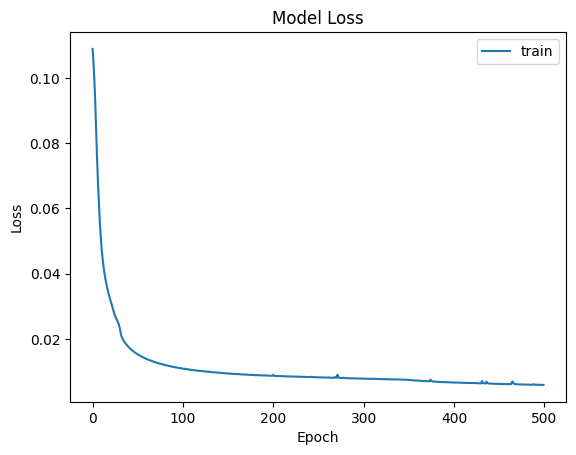

In [8]:
import matplotlib.pyplot as plt

# 훈련 손실 그래프
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper right')
plt.show()

1/1 [==============================] - 0s 12ms/step


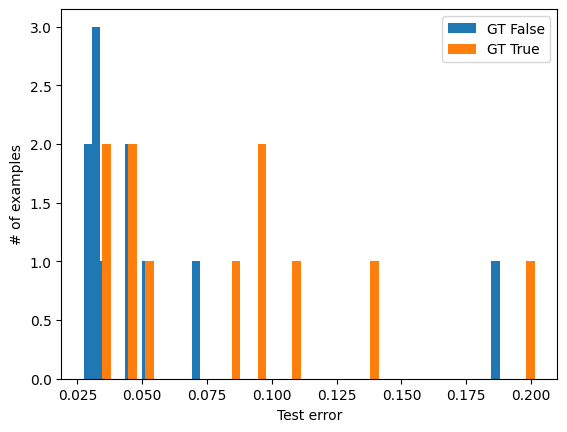

In [10]:
import numpy as np

scaled_test_data = data_loader.get_scaled_test_data(scaler)
scaled_test_data0 = data_loader.get_scaled_test_data(scaler)[:len(np.where(test_Y==False)[0])]
scaled_test_data1 = data_loader.get_scaled_test_data(scaler)[len(np.where(test_Y==False)[0]):]

reconstructions = model.predict(scaled_test_data)
test_error = tf.keras.losses.mae(reconstructions, scaled_test_data)

reconstructions0 = model.predict(scaled_test_data0)
test_error0 = tf.keras.losses.mae(reconstructions0, scaled_test_data0)

reconstructions1 = model.predict(scaled_test_data1)
test_error1 = tf.keras.losses.mae(reconstructions1, scaled_test_data1)

plt.hist(tf.reduce_mean(test_error0, axis=-1), bins=50)
plt.hist(tf.reduce_mean(test_error1, axis=-1), bins=50)
plt.xlabel("Test error")
plt.ylabel("# of examples")
plt.legend(['GT False', 'GT True'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("AUROC = {}".format(roc_auc_score(test_Y, tf.reduce_mean(test_error, axis=-1))))

# def print_stats(predictions, labels):
#     print("Accuracy = {}".format(accuracy_score(labels, predictions)))
#     print("Precision = {}".format(precision_score(labels, predictions)))
#     print("Recall = {}".format(recall_score(labels, predictions)))

# def predict(model, data, threshold):
#     losses = []
#     # for i in data:
#     reconstructions = model(data)
#     loss = tf.keras.losses.mae(reconstructions, data)
#     reconstructions_errors = tf.reduce_mean(loss, axis=-1)
#     return tf.math.less(reconstructions_errors, threshold)

# preds = predict(model, scaled_test_data, threshold)
# print_stats(preds.numpy(), test_Y)

AUROC = 0.8099173553719008
